## RAG Agent With DeepSeek-R1 And Ollama

In [ ]:
## 1. Download and Install Ollama
# Visit: https://ollama.com/download
# Choose the version for your OS (Windows), Install it locally
# > ollama pull deepseek-r1:1.5b

## Need install streamlit, langchain_core, langchain_community, langchain_ollama, pdfplumber

import os
import streamlit as st
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM

# --- Patient-Friendly Styling ---
st.markdown("""
    <style>
    .stApp {
        background-color: #FAFAFA;
        color: #2C3E50;
        font-family: "Segoe UI", sans-serif;
    }
    .stChatInput input {
        background-color: #F0F8FF !important;
        color: #2C3E50 !important;
        border: 1px solid #B0C4DE !important;
        border-radius: 8px;
    }
    .stChatMessage[data-testid="stChatMessage"]:nth-child(odd) {
        background-color: #E8F0FE !important;
        border: 1px solid #D0E3F0 !important;
        color: #2C3E50 !important;
        border-radius: 10px;
        padding: 15px;
        margin: 10px 0;
    }
    .stChatMessage[data-testid="stChatMessage"]:nth-child(even) {
        background-color: #FFF8E1 !important;
        border: 1px solid #FFE0B2 !important;
        color: #2C3E50 !important;
        border-radius: 10px;
        padding: 15px;
        margin: 10px 0;
    }
    .stChatMessage .avatar {
        background-color: #AEDFF7 !important;
        color: #000000 !important;
    }
    .stChatMessage p, .stChatMessage div {
        color: #2C3E50 !important;
    }
    .stFileUploader {
        background-color: #FFFFFF;
        border: 1px solid #DADADA;
        border-radius: 8px;
        padding: 15px;
    }
    h1, h2, h3 {
        color: #1A73E8 !important;
    }
    </style>
""", unsafe_allow_html=True)

# --- Prompt Template for AI Assistant ---
PROMPT_TEMPLATE = """
You are a compassionate and knowledgeable medical assistant. Use the provided medical literature to answer the patient's question.
If the information is unclear or not available, politely let them know. Keep your answer concisely, friendly, and informative, 
using plain English and no more than 50 words.

Patient's Question: {user_query}
Relevant Medical Content: {document_context}
Response:
"""

# --- Environment Setup ---
BASE_DIR = os.path.dirname(os.path.abspath(__file__))
PDF_STORAGE_PATH = os.path.join(BASE_DIR, 'document_store', 'pdfs')
os.makedirs(PDF_STORAGE_PATH, exist_ok=True)

EMBEDDING_MODEL = OllamaEmbeddings(model="deepseek-r1:1.5b")
VECTOR_DB = InMemoryVectorStore(EMBEDDING_MODEL)
LLM = OllamaLLM(model="deepseek-r1:1.5b")

# --- Combined Document Handling and Chunk Indexing ---
def process_and_index_pdf(uploaded_file):
    """
    Saves uploaded PDF, extracts and chunks its content, and stores chunks into a vector DB.
    Returns the list of document chunks.
    """
    file_path = os.path.join(PDF_STORAGE_PATH, uploaded_file.name)

    # Save file locally
    with open(file_path, "wb") as file:
        file.write(uploaded_file.getbuffer())

    # Load and split text from PDF into overlapping chunks
    loader = PDFPlumberLoader(file_path)
    documents = loader.load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
    chunks = splitter.split_documents(documents)

    # Store chunks in vector database
    VECTOR_DB.add_documents(chunks)
    return chunks

# --- Generate an AI Answer Based on Query and Retrieved Context ---
def answer_question(user_query):
    """
    Searches vector DB using the query and generates an answer using the LLM.
    """
    relevant_chunks = VECTOR_DB.similarity_search(user_query)

    if not relevant_chunks:
        return "I'm sorry, I couldn't find relevant information in the document to answer that."

    context = "\n\n".join([doc.page_content for doc in relevant_chunks])
    prompt = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    chain = prompt | LLM
    return chain.invoke({
        "user_query": user_query,
        "document_context": context
    })

# --- Streamlit App UI ---
st.title("🩺 MedGuide AI")
st.markdown("#### Your Friendly Medical Document Assistant")
st.markdown("Upload a medical research paper and ask any health-related questions you may have.")

uploaded_pdf = st.file_uploader(
    "📄 Upload a Medical Research Document (PDF)",
    type="pdf",
    help="Upload clinical guidelines, medical reviews, or diagnosis criteria.",
    accept_multiple_files=False
)

if uploaded_pdf:
    try:
        # Process file and build vector index
        process_and_index_pdf(uploaded_pdf)
        st.success("✅ Document processed successfully! Feel free to ask a medical question below.")
    except Exception as e:
        st.error(f"❌ Error processing document: {e}")
        st.stop()

    # User question input
    user_input = st.chat_input("💬 Ask your health question...")

    if user_input:
        with st.chat_message("user"):
            st.write(user_input)

        with st.spinner("Analyzing document..."):
            response = answer_question(user_input)

        with st.chat_message("assistant", avatar="🩺"):
            st.write(response)

 > streamlit run DeepSeek_RAG.py <br>
[Note]: Use a .ipynb notebook to display results clearly (Markdown).

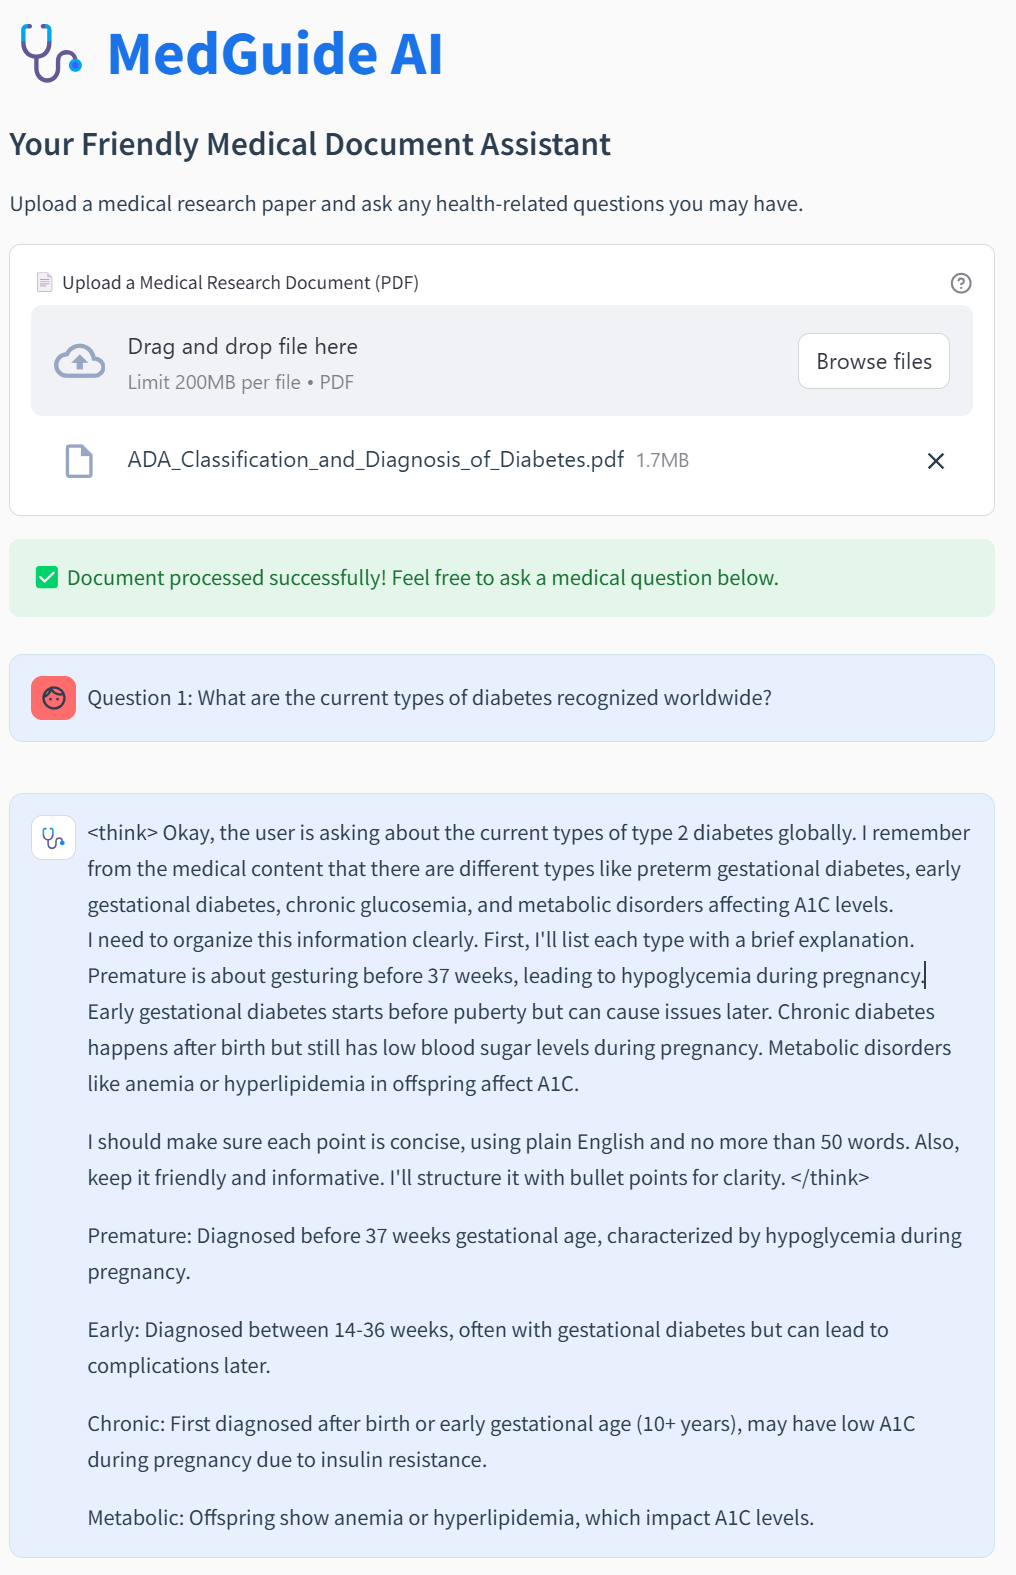